<a href="https://colab.research.google.com/github/jkakos/KaggleTitanic/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Titanic

This notebook is my first foray into a machine learning project. There was a lot of experimentation with different features, many of which were not used for my best model. So far my best submission had a 77.511% accuracy.

In [264]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab.output import eval_js
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [265]:
pd.set_option('display.width', 180)

# Load train and test data

In [266]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [267]:
root = pathlib.Path("./drive/MyDrive/Colab Notebooks/titanic/")
train = pd.read_csv(root.joinpath('train.csv'))
test = pd.read_csv(root.joinpath('test.csv'))
print(train)
print(train.info())

     PassengerId  Survived  Pclass                                               Name     Sex   Age  SibSp  Parch            Ticket     Fare Cabin Embarked
0              1         0       3                            Braund, Mr. Owen Harris    male  22.0      1      0         A/5 21171   7.2500   NaN        S
1              2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1      0          PC 17599  71.2833   C85        C
2              3         1       3                             Heikkinen, Miss. Laina  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN        S
3              4         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1      0            113803  53.1000  C123        S
4              5         0       3                           Allen, Mr. William Henry    male  35.0      0      0            373450   8.0500   NaN        S
..           ...       ...     ...                              

In [268]:
print(pd.concat([train, test], axis=0).isnull().sum().sort_values())

PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Embarked          2
Age             263
Survived        418
Cabin          1014
dtype: int64


There are missing values for Fare, Embarked, and Age, and a significant number missing for Cabin.

In [269]:
print(train.describe())

       PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


# Explore data

## Sex

Convert Sex from a categorical male/female to a binary number (1 for male or 0 for female). Rename this column Male for clarity.

In [270]:
train['Male'] = (train['Sex'] == 'male').astype(int)
train = train.drop('Sex', axis=1)

test['Male'] = (test['Sex'] == 'male').astype(int)
test = test.drop('Sex', axis=1)

## Title

Each passenger has a title, which may play some role in survival. For example, Master is a title used for young males whereas Mr is used for older ones. Survival on the Titanic generally followed 'women and children first,' so these may be useful. Additionally, passengers with fancier titles may have gotten privilege.

In [271]:
# Extract title from name
train['Title'] = train['Name'].str.extract(r', *[A-Za-z ]* ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(r', *[A-Za-z ]* ([A-Za-z]+)\.', expand=False)
print(train[['Title', 'Name']])
print(train['Title'].unique())
print(test['Title'].unique())

    Title                                               Name
0      Mr                            Braund, Mr. Owen Harris
1     Mrs  Cumings, Mrs. John Bradley (Florence Briggs Th...
2    Miss                             Heikkinen, Miss. Laina
3     Mrs       Futrelle, Mrs. Jacques Heath (Lily May Peel)
4      Mr                           Allen, Mr. William Henry
..    ...                                                ...
886   Rev                              Montvila, Rev. Juozas
887  Miss                       Graham, Miss. Margaret Edith
888  Miss           Johnston, Miss. Catherine Helen "Carrie"
889    Mr                              Behr, Mr. Karl Howell
890    Mr                                Dooley, Mr. Patrick

[891 rows x 2 columns]
['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']
['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


How do titles correlate with class and survival?

In [272]:
title_group = pd.concat([train, test], axis=0).groupby('Title')

grp = title_group[['Pclass', 'Survived']].agg({'Pclass': ['median', 'mean'], 'Survived': 'mean'})
grp.columns = ['_'.join(col).strip() for col in grp.columns.values]
grp['Count'] = title_group.size()
print(grp.sort_values('Survived_mean').round(2))

          Pclass_median  Pclass_mean  Survived_mean  Count
Title                                                     
Capt                1.0         1.00           0.00      1
Don                 1.0         1.00           0.00      1
Jonkheer            1.0         1.00           0.00      1
Rev                 2.0         2.00           0.00      8
Mr                  3.0         2.38           0.16    757
Dr                  1.0         1.25           0.43      8
Col                 1.0         1.00           0.50      4
Major               1.0         1.00           0.50      2
Master              3.0         2.66           0.57     61
Miss                3.0         2.35           0.70    260
Mrs                 2.0         1.94           0.79    197
Mlle                1.0         1.00           1.00      2
Mme                 1.0         1.00           1.00      1
Countess            1.0         1.00           1.00      1
Ms                  2.5         2.50           1.00     

There are many unique special titles belonging to few passengers which can be grouped. There are also only two passengers with the title Ms which could be grouped in with the Miss title.

In [273]:
special_titles = [
    'Capt', 'Col', 'Countess', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Mlle', 'Mme', 'Rev', 'Sir'
]
train['Title'] = train['Title'].replace(special_titles, 'Special')
test['Title'] = test['Title'].replace(special_titles, 'Special')
train['Title'] = train['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')

In [274]:
title_group = pd.concat([train, test], axis=0).groupby('Title')

grp = title_group[['Pclass', 'Survived']].agg({'Pclass': ['median', 'mean'], 'Survived': 'mean'})
grp.columns = ['_'.join(col).strip() for col in grp.columns.values]
grp['Count'] = title_group.size()
print(grp.sort_values('Survived_mean').round(2))

         Pclass_median  Pclass_mean  Survived_mean  Count
Title                                                    
Mr                 3.0         2.38           0.16    757
Special            1.0         1.31           0.42     32
Master             3.0         2.66           0.57     61
Miss               3.0         2.35           0.70    262
Mrs                2.0         1.94           0.79    197


We can see the 'women and children first' take effect here.

## Family size

The dataset provides SibSp and Parch which combine together siblings and spouses and parents and children. One could perhaps separate parents and children, but siblings and spouses might not be feasible. Instead, consider the overall family size.

In [275]:
train['FamSize'] = train['SibSp'] + train['Parch'] + 1
test['FamSize'] = test['SibSp'] + test['Parch'] + 1

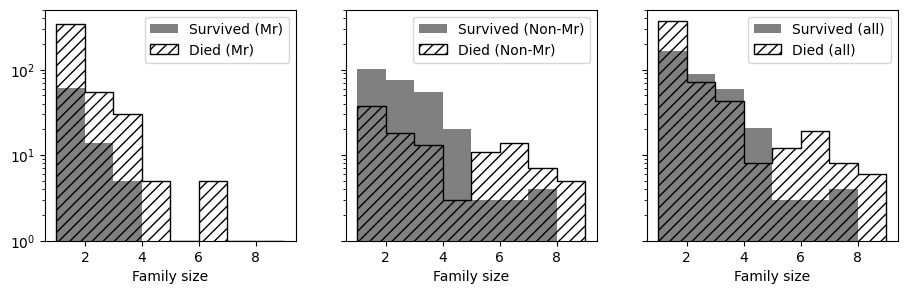

In [276]:
fig, ax = plt.subplots(figsize=(11, 3), ncols=3, sharex=True, sharey=True)
survived = train['Survived'] == 1
mr = train['Title'] == 'Mr'
fam_size = train['Famsize']
alone = fam_size == 1
bins = np.arange(1, 10, 1)
density = False

ax[0].hist(fam_size[survived & mr], bins=bins, color='gray', density=density, label='Survived (Mr)')
ax[0].hist(
    fam_size[~survived & mr], bins=bins, color='k', histtype='step', hatch='///', density=density, label='Died (Mr)'
)
ax[1].hist(fam_size[survived & ~mr], bins=bins, color='gray', density=density, label='Survived (Non-Mr)')
ax[1].hist(
    fam_size[~survived & ~mr], bins=bins, color='k', histtype='step', hatch='///', density=density, label='Died (Non-Mr)'
)
ax[2].hist(fam_size[survived], bins=bins, color='gray', density=density, label='Survived (all)')
ax[2].hist(fam_size[~survived], bins=bins, color='k', histtype='step', hatch='///', density=density, label='Died (all)')

for ax_ in ax:
    ax_.set(xlabel='Family size', yscale='log', ylim=(1, 500))
    ax_.legend()

High family size generally corresponds to low survival rate for non-Mr. For Mr, there is no significant dependence on family size. All Mr with family sizes over 5 died, but the statistics are low here. Passengers traveling alone who died were primarily Mr.

In [277]:
# train['MedFamSize'] = train['FamSize'].apply(lambda x: x in [2, 3, 4]).astype(int)
# test['MedFamSize'] = test['FamSize'].apply(lambda x: x in [2, 3, 4]).astype(int)

train['SmallFamSize'] = train['FamSize'].apply(lambda x: x < 5).astype(int)
test['SmallFamSize'] = test['FamSize'].apply(lambda x: x < 5).astype(int)

# train['SmallFamNonMr'] = ((train['FamSize'] < 5) & (train['Title'] != 'Mr')).astype(int)
# test['SmallFamNonMr'] = ((test['FamSize'] < 5) & (test['Title'] != 'Mr')).astype(int)

print(train.groupby('SmallFamSize')['Survived'].mean())
# print('\n', train.groupby('LargeFamSize')['Survived'].mean())

SmallFamSize
0    0.161290
1    0.400483
Name: Survived, dtype: float64


## Age

Missing ages need to be filled in. Using the passenger's title may help with this process. The titles Mr and Miss could correspond to older or younger passengers. If SibSp is greater than 1, then the passenger is traveling with siblings. In this case, it may be more likely that the passenger is younger.

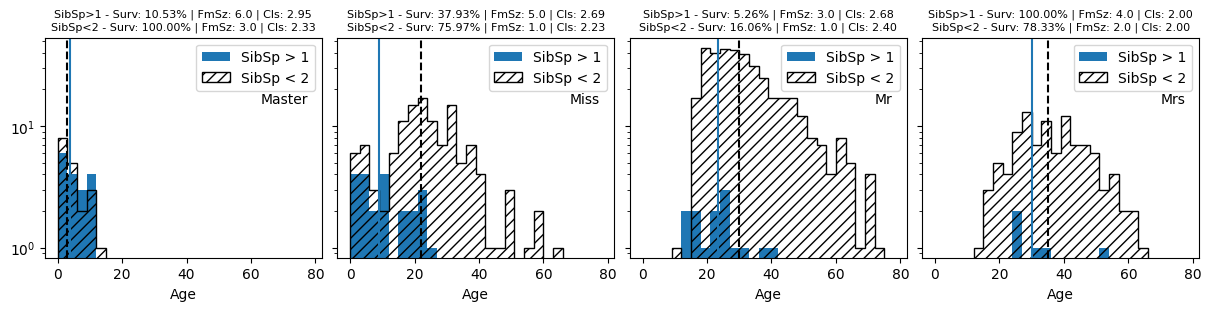

In [278]:
fig, ax = plt.subplots(figsize=(12, 3), ncols=4, sharex=True, sharey=True, constrained_layout=True)
for i, title in enumerate(['Master', 'Miss', 'Mr', 'Mrs']):
    has_title = train['Title'] == title
    sbsp_gtr_one = train.loc[has_title, 'SibSp'] > 1
    sbsp_one = train.loc[has_title, 'SibSp'] == 1
    sbsp_zero = train.loc[has_title, 'SibSp'] == 0

    y1 = train.loc[has_title & sbsp_gtr_one, 'Age']
    y2 = train.loc[has_title & ~sbsp_gtr_one, 'Age']
    ax[i].hist(y1, bins=np.arange(0, 80, 3), density=False, label='SibSp > 1')
    ax[i].hist(y2, bins=np.arange(0, 80, 3), color='k', histtype='step', hatch='///', density=False, label='SibSp < 2')
    ax[i].axvline(x=y1.median())
    ax[i].axvline(x=y2.median(), ls='--', color='k')

    title_text = (
        f"SibSp>1 - Surv: {train.loc[has_title & sbsp_gtr_one, 'Survived'].mean():.2%} | "
        f"FmSz: {train.loc[has_title & sbsp_gtr_one, 'FamSize'].median():.1f} | "
        f"Cls: {train.loc[has_title & sbsp_gtr_one, 'Pclass'].mean():.2f}\n"
        f"SibSp<2 - Surv: {train.loc[has_title & ~sbsp_gtr_one, 'Survived'].mean():.2%} | "
        f"FmSz: {train.loc[has_title & ~sbsp_gtr_one, 'FamSize'].median():.1f} | "
        f"Cls: {train.loc[has_title & ~sbsp_gtr_one, 'Pclass'].mean():.2f}"
    )
    ax[i].set(xlabel='Age', yscale='log')
    ax[i].set_title(title_text, fontsize=8)
    ax[i].text(0.95, 0.75, title, ha='right', va='top', transform=ax[i].transAxes)
    ax[i].legend()

Indeed, for Mr and Miss, there is an age difference between sub-populations with SibSp greater than 1 or 1 or less.

In [279]:
def impute_age_median(df: pd.DataFrame, default_age: float) -> pd.Series:
    """
    Impute median ages based on titles. The titles 'Miss' and 'Mr' can
    span a wide range of ages. If SibSp > 1, they likely have siblings
    with them and are likely younger, so impute ages based on this
    condition.

    If a sample based on title has no available ages, use 'default_age'.

    """
    ages = df['Age']

    if not len(ages.dropna()):
        ages = ages.fillna(default_age)
    elif df['Title'].iloc[0] in ['Miss', 'Mr']:
        likely_child = df['SibSp'] > 1
        likely_child_median_age = df.loc[likely_child, 'Age'].median()
        likely_not_child_median_age = df.loc[~likely_child, 'Age'].median()

        ages[likely_child] = ages[likely_child].fillna(likely_child_median_age)
        ages[~likely_child] = ages[~likely_child].fillna(likely_not_child_median_age)
    else:
        ages = ages.fillna(ages.median())

    return ages

We can impute ages based on passenger titles (e.g., Masters will be younger or Drs will be older).

In [280]:
median_age_train = train['Age'].median()
median_age_test = test['Age'].median()
title_w_missing_age_train = train.loc[train['Age'].isna(), 'Title'].unique()
title_w_missing_age_test = test.loc[test['Age'].isna(), 'Title'].unique()
print(title_w_missing_age_train)
print(title_w_missing_age_test)

['Mr' 'Mrs' 'Miss' 'Master' 'Special']
['Mr' 'Mrs' 'Miss' 'Master']


In [281]:
train['Age'] = train.groupby('Title').apply(
    impute_age_median, default_age=median_age_train
).reset_index(level=0, drop=True)
test['Age'] = test.groupby('Title').apply(
    impute_age_median, default_age=median_age_test
).reset_index(level=0, drop=True)

Since survival on the Titanic followed 'women and children first,' we might want to use ages or designate age groups.

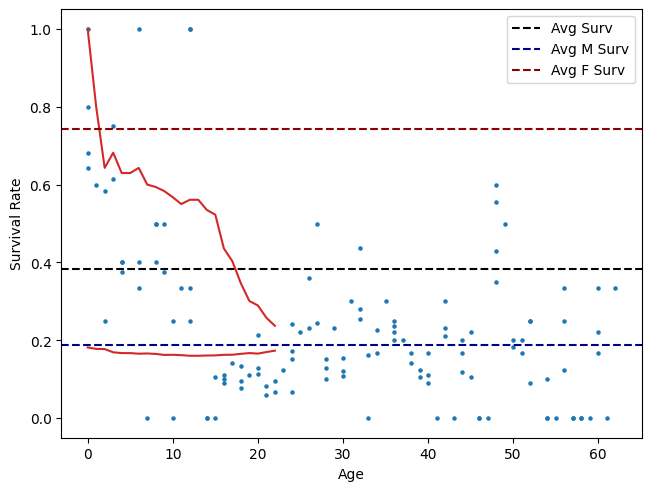

In [282]:
male = train['Male'] == 1

fig, ax = plt.subplots(constrained_layout=True)

for bin_step in [1, 2, 3, 4]:
    bins = np.arange(0, 64, bin_step)
    train['AgeGrp'] = np.digitize(train['Age'], bins=bins)
    male_survival = train.loc[male].groupby('AgeGrp')['Survived'].mean()
    male_survival = male_survival.reindex(np.arange(1, len(bins)), fill_value=-1)
    ax.scatter(bins[:-1], male_survival, s=5, color='tab:blue')

child_surv = []
for i in range(1, 24, 1):
    train['AgeGrp'] = np.digitize(train['Age'], bins=[i])
    child_surv.append(train.loc[male].groupby('AgeGrp')['Survived'].mean())

ax.plot(list(range(0, 23, 1)), child_surv, color='tab:red')

ax.axhline(y=train['Survived'].mean(), color='k', ls='--', label='Avg Surv')
ax.axhline(y=train.loc[male, 'Survived'].mean(), color='darkblue', ls='--', label='Avg M Surv')
ax.axhline(y=train.loc[~male, 'Survived'].mean(), color='darkred', ls='--', label='Avg F Surv')

ax.set(xlabel='Age', ylabel='Survival Rate', ylim=(-0.05, 1.05))
_ = ax.legend()

Male survival is generally higher until about age 10, so we could make that the boundary for the age group. Is this dependent on class? It may be the case that higher class children had better odds of survival than lower class children.

In [286]:
train['AgeGrp'] = np.digitize(train['Age'], bins=[10])
test['AgeGrp'] = np.digitize(test['Age'], bins=[10])
age_grp = train.groupby('AgeGrp')['Survived'].mean().reset_index()
age_grp['Count'] = train.groupby('AgeGrp').size()
print(age_grp)

   AgeGrp  Survived  Count
0       0  0.561644     73
1       1  0.367971    818


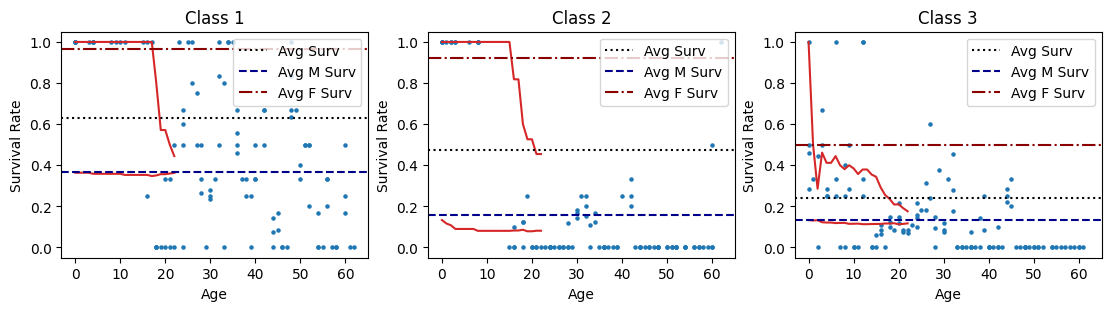

In [283]:
male = train['Male'] == 1

fig, ax = plt.subplots(figsize=(11, 3), ncols=3, constrained_layout=True)
for cls in [1, 2, 3]:
    i = cls - 1
    cls_cond = train['Pclass'] == cls
    for bin_step in [1, 2, 3, 4]:
        bins = np.arange(0, 64, bin_step)
        train['AgeGrp'] = np.digitize(train['Age'], bins=bins)
        male_survival = train.loc[male & cls_cond].groupby('AgeGrp')['Survived'].mean()
        male_survival = male_survival.reindex(np.arange(1, len(bins)), fill_value=-1)
        ax[i].scatter(bins[:-1], male_survival, s=5, color='tab:blue')

    child_surv = []
    for j in range(1, 24, 1):
        train['AgeGrp'] = np.digitize(train['Age'], bins=[j])
        child_surv.append(train.loc[male & cls_cond].groupby('AgeGrp')['Survived'].mean())

    ax[i].plot(list(range(0, 23, 1)), child_surv, color='tab:red')

    ax[i].axhline(y=train.loc[cls_cond, 'Survived'].mean(), color='k', ls=':', label='Avg Surv')
    ax[i].axhline(y=train.loc[male & cls_cond, 'Survived'].mean(), color='darkblue', ls='--', label='Avg M Surv')
    ax[i].axhline(y=train.loc[~male & cls_cond, 'Survived'].mean(), color='darkred', ls='-.', label='Avg F Surv')

    ax[i].set(xlabel='Age', ylabel='Survival Rate', ylim=(-0.05, 1.05), title=f'Class {cls}')
    _ = ax[i].legend()

Survival is lower for children in class 3 than higher classes. Survival generally seems lower at older ages for lower classes compared to class 1. Maybe encapsulate this by creating a new feature that combines age and class.

In general, lower age will give better odds of survival, but at a fixed age, a lower class number will also give better odds of survival. We might try age * class or some variant of that.

In [284]:
from typing import Callable

def plot_new_feature_by_class(
    ax: np.ndarray[plt.Axes],
    row: int,
    x1: pd.Series,
    x2: pd.Series,
    classification: pd.Series,
    y_fn: Callable[[pd.Series, pd.Series], pd.Series],
    label: str,
) -> None:
    for cls in [1, 2, 3]:
        i = cls - 1
        cls_cond = x2 == cls

        y = y_fn(x1[cls_cond], x2[cls_cond])
        y_other = y_fn(x1[~cls_cond], x2[~cls_cond])

        ax[row, i].scatter(x1[~cls_cond], y_other, s=10, color='gray')
        ax[row, i].scatter(x1[cls_cond], y, s=10, c=classification[cls_cond], cmap='viridis')
        ax[row, i].set(xlabel=x1.name, ylabel=label, title=f'Class {cls}')

    y_all = y_fn(x1, x2)
    ax[row, -1].scatter(x1, y_all, s=10, c=classification, cmap='viridis')
    ax[row, -1].set(xlabel=x1.name, ylabel=label, title=f'All')

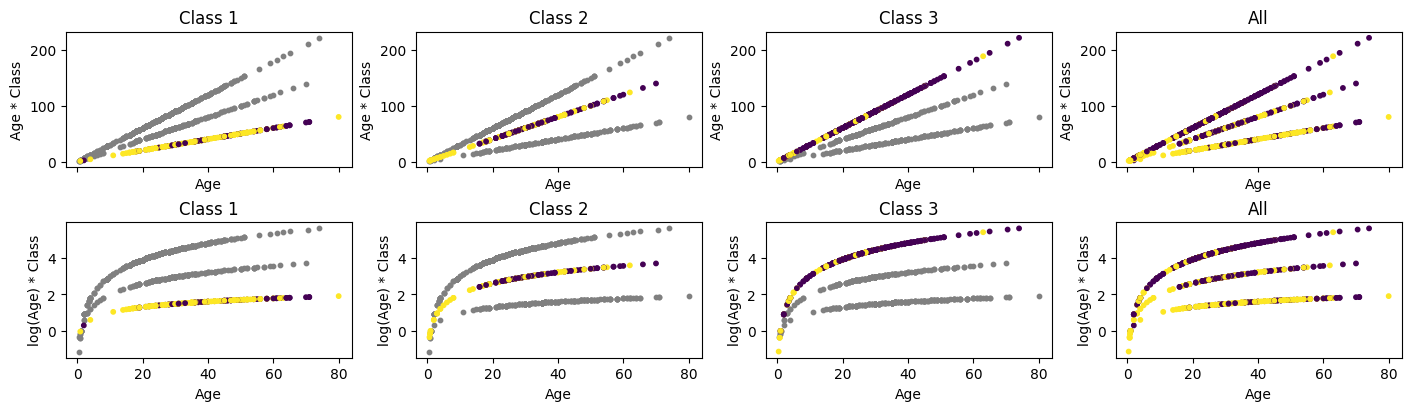

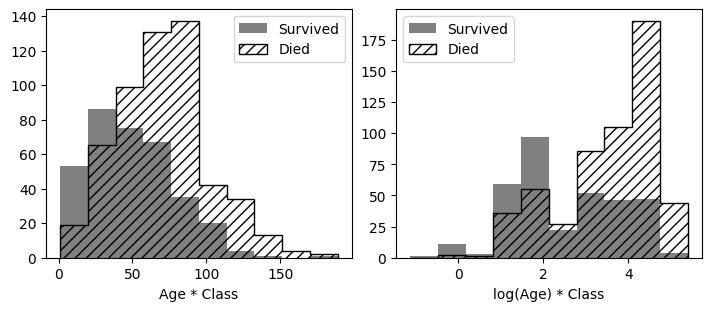

In [285]:
age = train['Age']
cls = train['Pclass']
survived = train['Survived'] == 1

get_y = lambda x, y: x * y
get_logy = lambda x, y: np.log10(x) * y

fig, ax = plt.subplots(figsize=(14, 4), nrows=2, ncols=4, sharex=True, sharey=False, constrained_layout=True)
plot_new_feature_by_class(ax, 0, age, cls, survived, get_y, 'Age * Class')
plot_new_feature_by_class(ax, 1, age, cls, survived, get_logy, 'log(Age) * Class')

fig, ax = plt.subplots(figsize=(7, 3), ncols=2, constrained_layout=True)
y = get_y(age, cls)
logy = get_logy(age, cls)
_, bins, _ = ax[0].hist(y[survived], color='gray', label='Survived')
ax[0].hist(y[~survived], bins=bins, histtype='step', hatch='///', color='k', label='Died')
_, bins, _ = ax[1].hist(logy[survived], color='gray', label='Survived')
ax[1].hist(logy[~survived], bins=bins, histtype='step', hatch='///', color='k', label='Died')
ax[0].set(xlabel='Age * Class')
ax[1].set(xlabel='log(Age) * Class')
ax[0].legend()
ax[1].legend()

In [287]:
train['Age*Class'] = train['Age'] * train['Pclass']
test['Age*Class'] = test['Age'] * test['Pclass']
train['log(Age)*Class'] = np.log10(train['Age']) * train['Pclass']
test['log(Age)*Class'] = np.log10(test['Age']) * test['Pclass']

In [288]:
def get_avg_survival(
    df: pd.DataFrame, feature: str, classification: str, n_bins: int, window_size_mult: int = 2
) -> tuple[list[float], list[float], list[float]]:
    """
    Calculate the average survival rate in bins along 'feature'. 'n_bins' will
    determine the step size that the mean is calculated in and 'window_size_mult'
    is the size of the window to consider in each direction as a multiple of the
    bin size.

    """
    surv = []
    err = []
    x = df[feature]
    bins = np.linspace(min(x), max(x), n_bins)
    window_size = (bins[1] - bins[0]) * window_size_mult

    for i, center in enumerate(bins):
        low = center - window_size
        high = center + window_size
        sample = train.loc[(x > low) & (x < high), classification]
        surv.append(sample.mean())
        err.append(sample.std() / np.sqrt(sample.size))

    return list(bins), surv, err

[Text(0.5, 0, 'log(Age)*Class'), Text(0, 0.5, 'Survival Rate')]

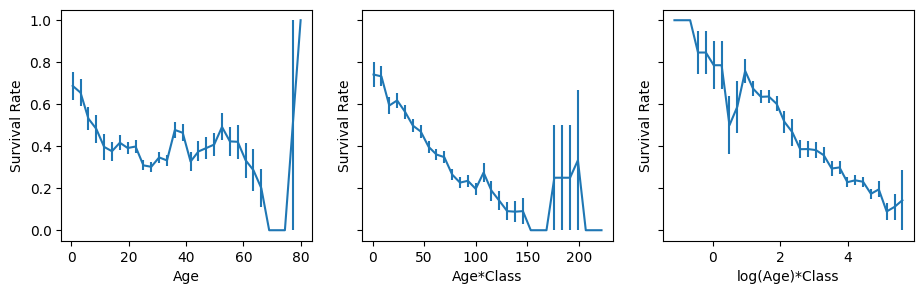

In [289]:
fig, ax = plt.subplots(figsize=(11, 3), ncols=3, sharey=True)
ax[0].errorbar(*get_avg_survival(train, 'Age', 'Survived', 30, 2))
ax[1].errorbar(*get_avg_survival(train, 'Age*Class', 'Survived', 30, 2))
ax[2].errorbar(*get_avg_survival(train, 'log(Age)*Class', 'Survived', 30, 2))
ax[0].set(xlabel='Age', ylabel='Survival Rate')
ax[1].set(xlabel='Age*Class', ylabel='Survival Rate')
ax[2].set(xlabel='log(Age)*Class', ylabel='Survival Rate')

Survival rate seems to correlate strongly with age\*class and log(age)\*class. Since log(age)\*class has a nicer relation, we'll use that.

## Cabin

In [290]:
# Mark whether a passenger has a cabin or not
train['HasCabin'] = train['Cabin'].notna().astype(int)
test['HasCabin'] = test['Cabin'].notna().astype(int)

In [291]:
print(train.groupby('HasCabin')['Survived'].mean())

HasCabin
0    0.299854
1    0.666667
Name: Survived, dtype: float64


Passengers who have a cabin are much more likely to survive than those that do not. It may be the case that this survival rate is high because class 1 passengers will tend to be the ones who have cabins.

In [292]:
hascabin = train.query("HasCabin == 1")
nocabin = train.query("HasCabin == 0")
classes = [1, 2, 3]
print(
    pd.DataFrame(
        {
            'Pclass': classes,
            'Survival w/ cabin': [hascabin.loc[hascabin['Pclass'] == cls, 'Survived'].mean() for cls in classes],
            'Survival w/o cabin': [nocabin.loc[nocabin['Pclass'] == cls, 'Survived'].mean() for cls in classes],
            'Fraction w/ cabin': [sum(hascabin['Pclass'] == cls) / sum(train['Pclass'] == cls) for cls in classes],
        }
    ).round(4)
)

   Pclass  Survival w/ cabin  Survival w/o cabin  Fraction w/ cabin
0       1             0.6648              0.4750             0.8148
1       2             0.8125              0.4405             0.0870
2       3             0.5000              0.2359             0.0244


Most passengers who have a cabin indeed belong to class 1. However, passengers in every class who have a cabin have a higher survival rate compared to passengers without a cabin.

We might also consider the deck to which the cabin corresponds. Some passengers have multiple cabins listed. Take whatever the highest deck level is.

In [293]:
cabins = train['Cabin'].dropna()
train.loc[train['Cabin'].isna(), 'Cabin'] = 'NAN'
test.loc[test['Cabin'].isna(), 'Cabin'] = 'NAN'
train['HighestDeck'] = train['Cabin'].apply(lambda x: sorted([c[0] for c in x.split()])[0])
test['HighestDeck'] = test['Cabin'].apply(lambda x: sorted([c[0] for c in x.split()])[0])

In [294]:
# There were 6 cabins on the S/boat deck
train['HighestDeck'] = train['HighestDeck'].apply(lambda x: 'S' if x in ['T', 'U', 'W', 'X', 'Y', 'Z'] else x)
test['HighestDeck'] = test['HighestDeck'].apply(lambda x: 'S' if x in ['T', 'U', 'W', 'X', 'Y', 'Z'] else x)

In [295]:
decks = ['S', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'N']
deck_to_int = {deck: i for (i, deck) in enumerate(decks)}
deck_to_int

{'S': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'N': 8}

In [296]:
deck_grp = pd.concat([train, test], axis=0).groupby('HighestDeck')

grp = deck_grp[['Pclass', 'Survived']].agg({'Pclass': ['median', 'mean'], 'Survived': 'mean'})
grp.columns = ['_'.join(col).strip() for col in grp.columns.values]
grp['Count'] = deck_grp.size()
print(grp.sort_values('Survived_mean', ascending=False).round(2))

             Pclass_median  Pclass_mean  Survived_mean  Count
HighestDeck                                                  
D                      1.0         1.13           0.76     46
E                      1.0         1.36           0.76     44
B                      1.0         1.00           0.74     65
C                      1.0         1.00           0.59     94
F                      2.0         2.28           0.58     18
G                      3.0         3.00           0.50      5
A                      1.0         1.00           0.47     22
N                      3.0         2.62           0.30   1014
S                      1.0         1.00           0.00      1


Some deck levels have better survival rates than others, even within a single class.

It's not clear that missing cabin values mean a passenger has no cabin, though, so these might be poor features to train on.

## Fare

We might also consider the fare of a passenger's ticket or what fare was paid per family member.

In [297]:
def impute_fare_median(df: pd.DataFrame) -> pd.Series:
    """
    Impute median fare based on class.

    """
    fares = df['Fare']
    fares = fares.fillna(fares.median())

    return fares

In [298]:
train['Fare'] = train.groupby('Pclass').apply(impute_fare_median).reset_index(level=0, drop=True)
test['Fare'] = test.groupby('Pclass').apply(impute_fare_median).reset_index(level=0, drop=True)
train['Fare'] = train['Fare'].map(lambda x: np.log10(x) if x > 0 else 0)
test['Fare'] = test['Fare'].map(lambda x: np.log10(x) if x > 0 else 0)

In [299]:
train['FarePerFamMember'] = train['Fare'] / train['FamSize']
test['FarePerFamMember'] = test['Fare'] / test['FamSize']

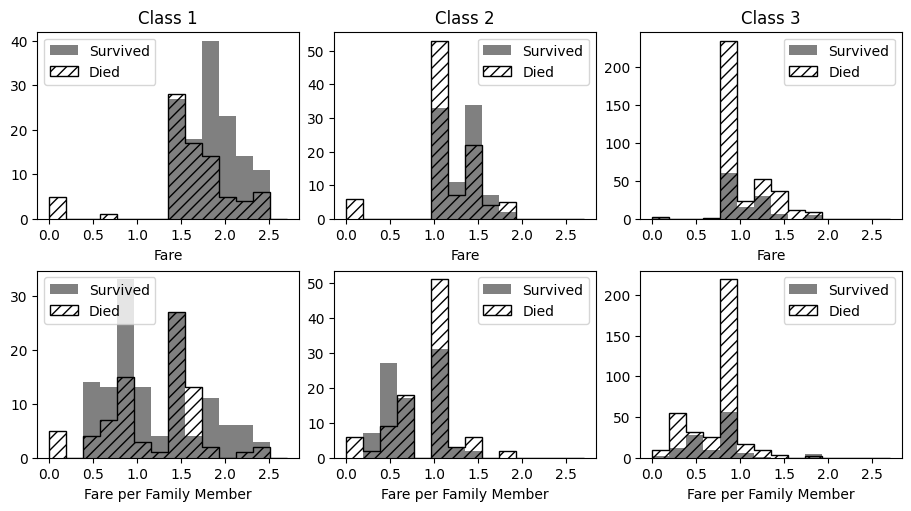

In [300]:
survived = train['Survived'] == 1
bins = np.linspace(0, 2.7, 15)
fig, ax = plt.subplots(figsize=(9, 5), nrows=2, ncols=3, constrained_layout=True)
for cls in [1, 2, 3]:
    i = cls - 1
    class_cond = train['Pclass'] == cls
    ax[0, i].hist(train.loc[class_cond & survived, 'Fare'], bins=bins, color='gray', label='Survived')
    ax[0, i].hist(
        train.loc[class_cond & ~survived, 'Fare'], bins=bins, histtype='step', hatch='///', color='k', label='Died'
    )
    ax[1, i].hist(train.loc[class_cond & survived, 'FarePerFamMember'], bins=bins, color='gray', label='Survived')
    ax[1, i].hist(
        train.loc[class_cond & ~survived, 'FarePerFamMember'],
        bins=bins,
        histtype='step',
        hatch='///',
        color='k',
        label='Died',
    )

    # ax[0].axvline(x=train['Fare'].median(), ls='--', color='k')
    ax[0, i].set(xlabel='Fare', title=f'Class {cls}')
    ax[1, i].set(xlabel='Fare per Family Member')
    ax[0, i].legend()
    _ = ax[1, i].legend()

In [301]:
above_mean = train['Fare'] > train['Fare'].median()
classes = [1, 2, 3]
print(
    pd.DataFrame(
        {
            'Pclass': classes,
            'Survival above mean': [train.loc[above_mean & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Survival below mean': [train.loc[~above_mean & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Fraction above mean': [sum(train.loc[above_mean, 'Pclass'] == cls) / sum(train['Pclass'] == cls) for cls in classes],
        }
    ).round(4)
)

   Pclass  Survival above mean  Survival below mean  Fraction above mean
0       1               0.6476               0.0000               0.9722
1       2               0.5870               0.3587               0.5000
2       3               0.2817               0.2264               0.2892


Survival might be tied to ticket fare beyond its correlation with class. Survival rate for above-median ticket fares is generally higher than below-median ticket fares, even for class 3, though not by much. Interestingly, none of the below-median ticket fare passengers in class 1 survived (granted this is only 3% of class 1).

## Embarked

In [302]:
train['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [303]:
print(train.groupby('Embarked')['Survived'].mean())

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


Passengers who embarked from 'C' were more likely to survive.

In [304]:
embC = train['Embarked'] == 'C'
embQ = train['Embarked'] == 'Q'
embS = train['Embarked'] == 'S'
classes = [1, 2, 3]
print(
    pd.DataFrame(
        {
            'Pclass': classes,
            'Class Surv': [train.loc[train['Pclass'] == cls, 'Survived'].mean() for cls in classes],
            'Surv from C': [train.loc[embC & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Surv not C': [train.loc[(embQ | embS) & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Frac from C': [sum(train.loc[embC, 'Pclass'] == cls) / sum(train['Pclass'] == cls) for cls in classes],
            'Surv from Q': [train.loc[embQ & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Surv not Q': [train.loc[(embC | embS) & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Frac from Q': [sum(train.loc[embQ, 'Pclass'] == cls) / sum(train['Pclass'] == cls) for cls in classes],
            'Surv from S': [train.loc[embS & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Surv not S': [train.loc[(embQ | embC) & (train['Pclass'] == cls), 'Survived'].mean() for cls in classes],
            'Frac from S': [sum(train.loc[embS, 'Pclass'] == cls) / sum(train['Pclass'] == cls) for cls in classes],
        }
    ).round(4)
)

   Pclass  Class Surv  Surv from C  Surv not C  Frac from C  Surv from Q  Surv not Q  Frac from Q  Surv from S  Surv not S  Frac from S
0       1      0.6296       0.6941      0.5814       0.3935       0.5000      0.6274       0.0093       0.5827      0.6897       0.5880
1       2      0.4728       0.5294      0.4671       0.0924       0.6667      0.4696       0.0163       0.4634      0.5500       0.8913
2       3      0.2424       0.3788      0.2212       0.1344       0.3750      0.2196       0.1466       0.1898      0.3768       0.7189


# Scale features



In [305]:
def scale_data(
    df: pd.DataFrame, features: list[str], classification: str | None,  oversample: bool = False
) -> pd.DataFrame:
    """
    Apply the standard scaler to 'features' and oversample if 'oversample' is True.

    """
    if classification is not None:
        y = df[classification]
    else:
        y = None
        if oversample:
            raise ValueError("Cannot oversample if 'classification' is not given.")

    dtypes = df.dtypes
    unscaled_features = [x for x in df.columns if x not in features]

    df = pd.DataFrame(
        make_column_transformer((StandardScaler(), features), remainder='passthrough').fit_transform(df),
        columns=(features + unscaled_features)
    )
    # ensure dtypes are maintained
    for col in df:
        df[col] = df[col].astype(dtypes[col])

    if oversample:
        ros = RandomOverSampler()
        df, y = ros.fit_resample(df.drop(classification, axis=1), df[classification])

    if classification is not None:
        df[classification] = y.values

    return df

In [306]:
# scale_cols = ['Age', 'SibSp', 'Parch', 'FamSize', 'Fare']
scale_cols = [
    # 'Age',
    # 'SibSp',
    # 'Parch',
    # 'FamSize',
    # 'Fare',
    'Age*Class',

]
features = [
    'Pclass',
    # 'Age',
    # 'AgeGrp',
    # 'Age*Class',
    'log(Age)*Class',
    # 'SibSp',
    # 'Parch',
    'SmallFamSize',
    # 'MedFamSize',
    # 'LargeFamSize',
    # 'SmallFamNonMr',
    # 'Fare',
    # 'FarePerFamMember',
    'Male',
    # 'HasCabin',
    # 'Title_Mr',
    # 'Title_Master',
    # 'Title_Miss',
    # 'Title_Mrs',
    # 'Title_Special',
    # 'Embarked_C',
    # 'Embarked_Q',
    # 'Embarked_S',
]
classification = ['Survived']

# train = pd.get_dummies(train, columns=['Title', 'Embarked'], dtype=int)
# test = pd.get_dummies(test, columns=['Title', 'Embarked'], dtype=int)

In [307]:
train, valid = np.split(train.sample(frac=1), [int(0.85 * len(train))])

train = scale_data(train, scale_cols, classification[0], oversample=False)
valid = scale_data(valid, scale_cols, classification[0], oversample=False)
test = scale_data(test, scale_cols, None, oversample=False)

train = train[features + classification]
valid = valid[features + classification]

print(train[features])

     Pclass  log(Age)*Class  SmallFamSize  Male
0         2        3.124586             1     1
1         3        3.836261             1     1
2         2        2.760422             1     0
3         3        4.341474             1     1
4         1        1.579784             1     0
..      ...             ...           ...   ...
752       2        2.894316             1     1
753       1        1.544068             1     1
754       1        1.431364             1     1
755       3        2.862728             0     1
756       3        4.167498             1     1

[757 rows x 4 columns]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# Visualize features

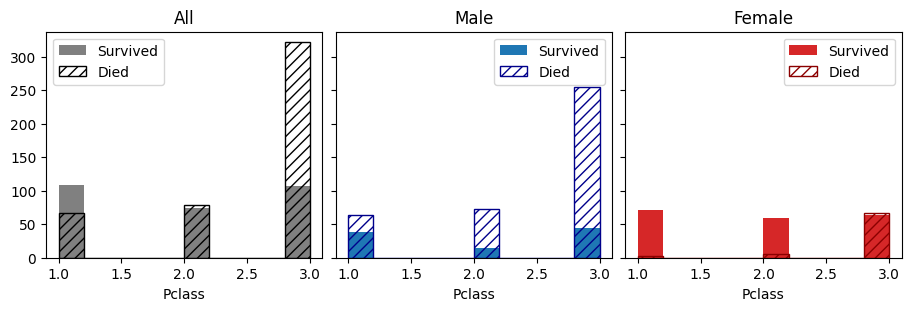

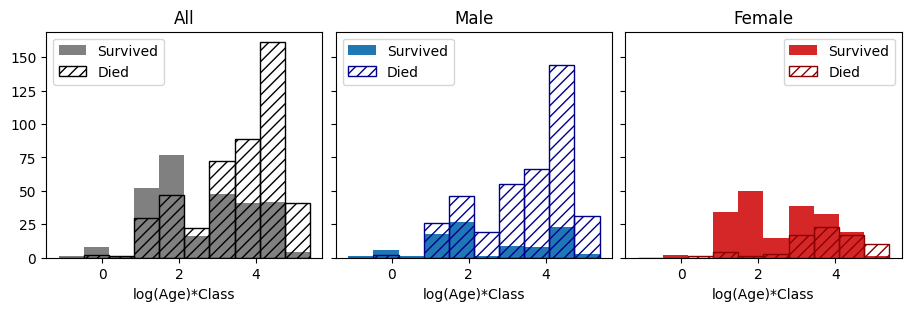

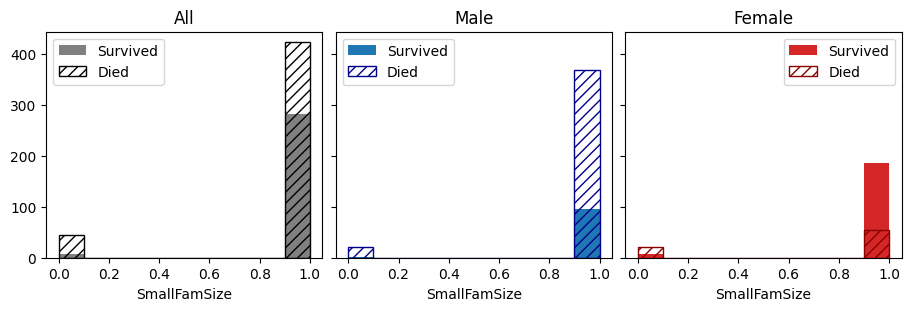

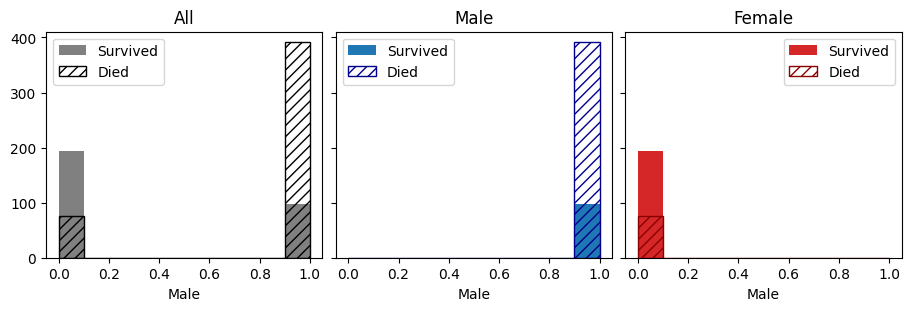

In [308]:
eval_js('google.colab.output.setIframeHeight("400")')
cols = train.columns
survived = train['Survived'] == 1
male = train['Male']
density = False

for col in features:
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(9, 3), ncols=3, sharex=True, sharey=True, constrained_layout=True)
    surv_male = train.loc[survived & male, col]
    died_male = train.loc[~survived & male, col]
    surv_female = train.loc[survived & ~male, col]
    died_female = train.loc[~survived & ~male, col]

    _, bins, *_ = ax1.hist(train.loc[survived, col], color='grey', density=density, label='Survived')
    ax1.hist(train.loc[~survived, col], bins=bins, facecolor='none', edgecolor='k', hatch='///', label='Died')
    ax2.hist(surv_male, bins=bins, color='tab:blue', density=density, label='Survived')
    ax2.hist(died_male, bins=bins, facecolor='none', edgecolor='darkblue', hatch='///', density=density, label='Died')
    ax3.hist(surv_female, bins=bins, color='tab:red', density=density, label='Survived')
    ax3.hist(died_female, bins=bins, facecolor='none', edgecolor='darkred', hatch='///', density=density, label='Died')

    for ax in [ax1, ax2, ax3]:
        ax.set(xlabel=col)
        ax.legend()

    ax1.set_title('All')
    ax2.set_title('Male')
    ax3.set_title('Female')

plt.show()

# Test different models

In [309]:
model_classes = {
    # 'knn': KNeighborsClassifier,
    'rf': RandomForestClassifier,
    # 'lr': LogisticRegression,
    # 'nb': GaussianNB,
    'svm': SVC,
    'xgb': XGBClassifier,
}

In [310]:
models = {
    model_name: model().fit(train[features], train[classification].values.reshape(-1))
    for (model_name, model) in model_classes.items()
}

In [311]:
validation = train

In [312]:
preds = {model_name: model.predict(validation[features]) for (model_name, model) in models.items()}

## Classification report

In [313]:
eval_js('google.colab.output.setIframeHeight("400")')
for model_name, pred in preds.items():
    print(f"{model_name}\n", classification_report(validation[classification], pred))

rf
               precision    recall  f1-score   support

           0       0.89      0.94      0.91       467
           1       0.90      0.80      0.85       290

    accuracy                           0.89       757
   macro avg       0.89      0.87      0.88       757
weighted avg       0.89      0.89      0.89       757

svm
               precision    recall  f1-score   support

           0       0.82      0.88      0.85       467
           1       0.79      0.69      0.74       290

    accuracy                           0.81       757
   macro avg       0.80      0.79      0.79       757
weighted avg       0.81      0.81      0.81       757

xgb
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       467
           1       0.89      0.79      0.84       290

    accuracy                           0.88       757
   macro avg       0.88      0.86      0.87       757
weighted avg       0.88      0.88      0.88       757



## Cross validation score

In [314]:
scores = {}
for model_name, model in models.items():
    scores[model_name] = cross_val_score(
        model, validation[classification], preds[model_name], cv=10, scoring='accuracy'
    )

In [315]:
score_vals = scores.values()
print(
    pd.DataFrame(
        {
            'Model': scores.keys(),
            'Score': [score.mean() * 100 for score in score_vals],
            'Std': [score.std() * 100 for score in score_vals],
        }
    ).sort_values('Score', ascending=False).round(2)
)

  Model  Score   Std
0    rf  88.89  3.72
2   xgb  88.10  3.27
1   svm  80.96  4.59


# Tune best model

In [338]:
best_model = 'rf'

In [339]:
print(
    pd.DataFrame({'feature': features, 'importance': models[best_model].feature_importances_ * 100}).sort_values(
        'importance', ascending=False
    ).round(2)
)

          feature  importance
1  log(Age)*Class       50.70
3            Male       34.42
0          Pclass        9.90
2    SmallFamSize        4.97


In [340]:
conf_matrix = confusion_matrix(validation[classification], models[best_model].predict(validation[features]))
conf_matrix

array([[440,  27],
       [ 57, 233]])

The random forest classifier has an accuracy of 88.9% on the train set. What about the validation set?

In [341]:
y = models[best_model].predict(valid[features])
cvs = cross_val_score(model, valid[classification], y, cv=10, scoring='accuracy')

print(f'{best_model}\n', classification_report(valid[classification], y))
print(f"{cvs.mean():.2%} +/- {cvs.std():.2%}")

rf
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        82
           1       0.88      0.83      0.85        52

    accuracy                           0.89       134
   macro avg       0.89      0.88      0.88       134
weighted avg       0.89      0.89      0.89       134

88.68% +/- 10.87%


Run GridSearchCV to find the best parameters

In [342]:
if best_model in ['rf', 'xgb']:
    param_grid = {
        # 'n_estimators': list(range(100, 300, 50)),
        'max_depth': [None, 2, 4, 6],
    }
    if best_model == 'rf':
        param_grid['criterion'] = ['gini', 'entropy']
        param_grid['max_features'] = ['sqrt', 'log2', None, 2, 3]

elif best_model == 'svm':
    param_grid = {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001],
    }

elif best_model == 'lr':
    param_grid = {
        'penalty': [None, 'l2'],
    }

grid = GridSearchCV(models[best_model], param_grid, refit=True, verbose=0)
grid.fit(validation[features], validation[classification].values.reshape(-1))
print(f"Best params: {grid.best_params_}")

Best params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 3}


In [321]:
model = model_classes[best_model](**grid.best_params_).fit(train[features], train[classification].values.reshape(-1))
y = model.predict(validation[features])
cvs = cross_val_score(grid, validation[classification], y, cv=10, scoring='accuracy')

print(f'{best_model}\n', classification_report(validation[classification], y))
print(f"{cvs.mean():.2%} +/- {cvs.std():.2%}")

rf
               precision    recall  f1-score   support

           0       0.86      0.93      0.89       467
           1       0.88      0.75      0.81       290

    accuracy                           0.86       757
   macro avg       0.87      0.84      0.85       757
weighted avg       0.86      0.86      0.86       757

86.38% +/- 3.30%


In [322]:
print(
    pd.DataFrame({'feature': features, 'importance': model.feature_importances_ * 100}).sort_values(
        'importance', ascending=False
    ).round(2)
)

          feature  importance
3            Male       43.35
1  log(Age)*Class       37.43
0          Pclass       12.13
2    SmallFamSize        7.10


In [327]:
y = model.predict(valid[features])
cvs = cross_val_score(model, valid[classification], y, cv=10, scoring='accuracy')

print(f'{best_model}\n', classification_report(valid[classification], y))
print(f"{cvs.mean():.2%} +/- {cvs.std():.2%}")

rf
               precision    recall  f1-score   support

           0       0.87      0.96      0.91        82
           1       0.93      0.77      0.84        52

    accuracy                           0.89       134
   macro avg       0.90      0.87      0.88       134
weighted avg       0.89      0.89      0.89       134

88.74% +/- 7.02%


The accuracy has gone down slightly when running on the train set but gone up a small amount on the validation set.

# Save results

In [337]:
predictions = model.predict(test[features])
results = test[['PassengerId']].copy()
results['Survived'] = predictions
save_dir = root.joinpath('submissions')
save_dir.mkdir(parents=True, exist_ok=True)
results.to_csv(save_dir.joinpath('submission_v13.csv'), index=False)

After testing the pre-grid search and post-grid search models, the post-grid search model scored 77.511% accuracy on the test set (the pre-grid search model scored 73.684%). The XGBClassifier was also tested and scored 75.598%.

In [330]:
import joblib

model_dir = root.joinpath('model')
model_dir.mkdir(parents=True, exist_ok=True)
# joblib.dump(model, model_dir.joinpath('rf_0.77511.pkl'))

['drive/MyDrive/Colab Notebooks/titanic/model/rf_0.77511.pkl']